In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
import tqdm as tqdm
import pickle 
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import gc

In [2]:
file_list = glob.glob("dataset/yellow_tripdata_2016-*.csv")

In [3]:
df_all = pd.concat((pd.read_csv(f) for f in file_list), ignore_index=True)

In [4]:
print(df_all.shape)
df_all.head()

(34499859, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8


In [5]:
df_all['tpep_pickup_datetime'] = pd.to_datetime(df_all['tpep_pickup_datetime'])

In [6]:
df_all['hour'] = df_all['tpep_pickup_datetime'].dt.hour
df_all['day'] = df_all['tpep_pickup_datetime'].dt.day
df_all['weekday'] = df_all['tpep_pickup_datetime'].dt.day_name()
df_all['month'] = df_all['tpep_pickup_datetime'].dt.month_name()

In [7]:
df_all.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,hour,day,weekday,month
0,2,2016-01-01,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,...,0.5,0.5,0.0,0.0,0.3,8.8,0,1,Friday,January
1,2,2016-01-01,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,...,0.5,0.5,0.0,0.0,0.3,19.3,0,1,Friday,January
2,2,2016-01-01,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,...,0.5,0.5,0.0,0.0,0.3,34.3,0,1,Friday,January
3,2,2016-01-01,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,...,0.0,0.5,0.0,0.0,0.3,17.3,0,1,Friday,January
4,2,2016-01-01,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,...,0.0,0.5,0.0,0.0,0.3,8.8,0,1,Friday,January


In [8]:
df_all = df_all[
    df_all['pickup_latitude'].between(40.5774, 40.9176) &
    df_all['pickup_longitude'].between(-74.15, -73.7004)
]
coords = df_all[['pickup_latitude', 'pickup_longitude']].dropna()
X = coords.to_numpy()

In [10]:
X_sample = X[np.random.choice(X.shape[0], size=500000, replace=False)]

In [10]:
inertias = []
silhouettes = []
k_range = [3, 5, 8, 12, 16, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80]

In [11]:
for k in tqdm.tqdm(k_range):
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=10000, random_state=42)
    labels = kmeans.fit_predict(X_sample)
    
    inertias.append(kmeans.inertia_)
    
    # Silhouette score
    score = silhouette_score(X_sample, labels)
    silhouettes.append(score)

100%|██████████| 15/15 [8:09:16<00:00, 1957.08s/it]  


In [13]:
results = {
    'k_range': list(k_range),
    'silhouettes': silhouettes,
    'inertias': inertias
}

with open('kmeans_silhouette_results.pkl', 'wb') as f:
    pickle.dump(results, f)

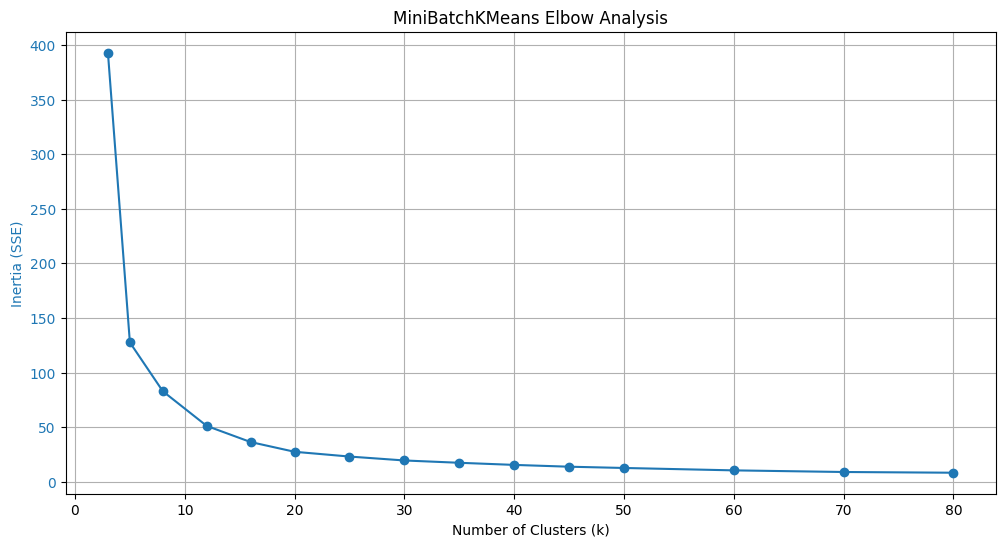

In [16]:
# Plot Inertia (Elbow) and Silhouette Score
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (SSE)', color=color)
ax1.plot(k_range, inertias, marker='o', color=color, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)

plt.title('MiniBatchKMeans Elbow Analysis')
plt.grid(True)
plt.show()

In [17]:
with open('kmeans_silhouette_results.pkl', 'rb') as f:
    loaded_results = pickle.load(f)

print(loaded_results['silhouettes'])

[0.6537401588093629, 0.4312633623133878, 0.3447915197228298, 0.37837045125567415, 0.3985872288023414, 0.3910326298030001, 0.3855498102161054, 0.3752218736566855, 0.3682168546934568, 0.37334988311073714, 0.37194848786138945, 0.3677368704724222, 0.3671009896911936, 0.36244502975407106, 0.35864826939699296]


In [ ]:
k_optimal = 16
kmeans = MiniBatchKMeans(n_clusters=k_optimal, batch_size=10000, random_state=42)
cluster_labels = kmeans.fit_predict(X)

In [ ]:
coords['pickup_cluster'] = cluster_labels

In [12]:
chunk_size = 1000000
chunks = []

for i in range(0, len(df_all), chunk_size):
    print(f"Processing chunk {i // chunk_size + 1}...")
    
    chunk = df_all.iloc[i:i + chunk_size].copy()
    merged_chunk = pd.merge(
        chunk,
        coords.drop_duplicates(subset=['pickup_latitude', 'pickup_longitude']),
        on=['pickup_latitude', 'pickup_longitude'],
        how='inner'
    )
    
    chunks.append(merged_chunk)
    
    # Free memory
    del chunk, merged_chunk
    gc.collect()

df_filtered = pd.concat(chunks, ignore_index=True)

# Final cleanup
del chunks
gc.collect()

print("Merging completed successfully.")

Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...
Processing chunk 21...
Processing chunk 22...
Processing chunk 23...
Processing chunk 24...
Processing chunk 25...
Processing chunk 26...
Processing chunk 27...
Processing chunk 28...
Processing chunk 29...
Processing chunk 30...
Processing chunk 31...
Processing chunk 32...
Processing chunk 33...
Processing chunk 34...
Merging completed successfully.


In [ ]:
cluster_centers = coords.groupby('cluster')[['pickup_latitude', 'pickup_longitude']].mean().reset_index()
cluster_centers.columns = ['cluster', 'avg_latitude', 'avg_longitude']
cluster_centers

,cluster,avg_latitude,avg_longitude
0,0,40.727105,-74.000862
1,1,40.646799,-73.784862
2,2,40.775398,-73.955701
3,3,40.752748,-73.990737
4,4,40.770549,-73.869150
5,5,40.757953,-73.971247
6,6,40.794646,-73.968942
7,7,40.763775,-73.984123
8,8,40.688852,-73.970862
9,9,40.711100,-74.010099


In [15]:
geolocator = Nominatim(user_agent="ride-hailing-clustering")
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
cluster_centers['location'] = cluster_centers.apply(
    lambda row: geocode((row['avg_latitude'], row['avg_longitude']), language='en').address,
    axis=1
)

In [17]:
print(cluster_centers[['cluster', 'avg_latitude', 'avg_longitude', 'location']])

    cluster  avg_latitude  avg_longitude  \
0         0     40.727105     -74.000862   
1         1     40.646799     -73.784862   
2         2     40.775398     -73.955701   
3         3     40.752748     -73.990737   
4         4     40.770549     -73.869150   
5         5     40.757953     -73.971247   
6         6     40.794646     -73.968942   
7         7     40.763775     -73.984123   
8         8     40.688852     -73.970862   
9         9     40.711100     -74.010099   
10       10     40.779383     -73.980146   
11       11     40.812775     -73.944956   
12       12     40.741346     -73.984015   
13       13     40.752995     -73.925267   
14       14     40.742047     -74.001206   
15       15     40.725717     -73.986843   

                                             location  
0   Padua Friary, 151, Thompson Street, University...  
1   Queens, Queens County, New York, 11430, United...  
2   211, East 81st Street, Upper East Side, Manhat...  
3   225, West 36th Street, 

In [ ]:
cluster_centers[['cluster', 'location']].to_csv('dataset/cluster_location.csv', index=False)

In [19]:
cluster_location_map = {
    0: "Padua Friary, 151, Thompson Street, University Village, Manhattan, New York County, New York, 10012, United States",
    1: "Queens, Queens County, New York, 11430, United States",
    2: "211, East 81st Street, Upper East Side, Manhattan Community Board 8, Manhattan, New York County, New York, 10028, United States",
    3: "225, West 36th Street, Garment District, Manhattan Community Board 5, Manhattan, New York County, New York, 10018, United States",
    4: "Grand Central Parkway, Queens, Queens County, New York, 11371, United States",
    5: "Turtle Bay, Manhattan Community Board 6, Manhattan, New York County, New York, 10152, United States",
    6: "Public School 163, 163, West 97th Street, Manhattan Valley, Manhattan Community Board 7, Manhattan, New York County, New York, 10025, United States",
    7: "Aro, 242, West 53rd Street, Clinton, Manhattan Community Board 5, Manhattan, New York County, New York, 10019, United States",
    8: "289, Adelphi Street, Fort Greene, Brooklyn, Kings County, New York, 11205, United States",
    9: "Millennium, 55, Church Street, Tribeca, Manhattan, New York County, New York, 10007, United States",
    10: "160, West 74th Street, Upper West Side, Manhattan Community Board 7, Manhattan, New York County, New York, 10023, United States",
    11: "2239, Adam Clayton Powell Jr. Boulevard, Manhattan Community Board 10, Manhattan, New York County, New York, 10027, United States",
    12: "69th Regiment Armory, 68, Lexington Avenue, Rose Hill, Manhattan Community Board 5, Manhattan, New York County, New York, 10010, United States",
    13: "36-50, 38th Street, Sunnyside Gardens, Queens, Queens County, New York, 11101, United States",
    14: "149, 8th Avenue, Chelsea, Manhattan Community Board 4, Manhattan, New York County, New York, 10011, United States",
    15: "81, 1st Avenue, East Village, Manhattan Community Board 3, Manhattan, New York County, New York, 10003, United States",
}

In [5]:
payment_method_type = {
    1: "Credit card",
    2: "Cash",
    3: "No charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided trip"
}

In [6]:
rate_code_type = {
    1: "Standard rate",
    2: "JFK",
    3: "Newark",
    4: "Nassau or Westchester",
    5: "Negotiated fare",
    6: "Group ride"
}

In [ ]:
df_filtered["location"] = df_filtered["cluster"].map(cluster_location_map)
df_filtered["payment_method"] = df_filtered["payment_type"].map(payment_method_type)
df_filtered["rate_type"] = df_filtered["RatecodeID"].map(rate_code_type)

In [8]:
df_filtered.to_csv('dataset/cleaned_2016_tripdata.csv', index=False)